# Recurrent Neural Nets - Fake News

![RNNs](./images/RNN-unrolled.png)

<img src='https://media.giphy.com/media/l0Iyau7QcKtKUYIda/giphy.gif'>


In [1]:
!pip install tqdm
!conda install -y Pillow

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, LSTM, Embedding, Reshape
from keras.models import load_model, model_from_json

from sklearn.model_selection import train_test_split

import os
import urllib

from urllib.request import urlretrieve

from os import mkdir, makedirs, remove, listdir

from collections import Counter

from utilties import *

Fetching package metadata ...........
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /root/miniconda3:
#
pillow                    4.2.1                    py36_0  


Using TensorFlow backend.


In [2]:
folder_path = 'data'

file = './data/fakenews.zip'
url = 'https://github.com/GeorgeMcIntire/fake_real_news_dataset/raw/master/fake_or_real_news.csv.zip'
downloadData(file, url)

#################################    
# Download GLOVE vector dataset
#################################
file = './data/glove.6B.zip'
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
downloadData(file, url)

with open('./data/glove.6B.50d.txt','rb') as f:
    lines = f.readlines()
    
glove_weights = np.zeros((len(lines), 50))
words = []
for i, line in enumerate(lines):
    word_weights = line.split()
    words.append(word_weights[0])
    weight = word_weights[1:]
    glove_weights[i] = np.array([float(w) for w in weight])
word_vocab = [w.decode("utf-8") for w in words]

word2glove = dict(zip(word_vocab, glove_weights))

Preprocessing steps: lower case, remove urls, some punctuations etc.

In [3]:
from keras.engine.topology import Layer
import keras.backend as K
from keras import initializers
import numpy as np

class Embedding2(Layer):

    def __init__(self, input_dim, output_dim, fixed_weights, embeddings_initializer='uniform', 
                 input_length=None, **kwargs):
        kwargs['dtype'] = 'int32'
        if 'input_shape' not in kwargs:
            if input_length:
                kwargs['input_shape'] = (input_length,)
            else:
                kwargs['input_shape'] = (None,)
        super(Embedding2, self).__init__(**kwargs)
    
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embeddings_initializer = embeddings_initializer
        self.fixed_weights = fixed_weights
        self.num_trainable = input_dim - len(fixed_weights)
        self.input_length = input_length
        
        w_mean = fixed_weights.mean(axis=0)
        w_std = fixed_weights.std(axis=0)
        self.variable_weights = w_mean + w_std*np.random.randn(self.num_trainable, output_dim)

    def build(self, input_shape, name='embeddings'):        
        fixed_weight = K.variable(self.fixed_weights, name=name+'_fixed')
        variable_weight = K.variable(self.variable_weights, name=name+'_var')
        
        self._trainable_weights.append(variable_weight)
        self._non_trainable_weights.append(fixed_weight)
        
        self.embeddings = K.concatenate([fixed_weight, variable_weight], axis=0)
        
        self.built = True

    def call(self, inputs):
        if K.dtype(inputs) != 'int32':
            inputs = K.cast(inputs, 'int32')
        out = K.gather(self.embeddings, inputs)
        return out

    def compute_output_shape(self, input_shape):
        if not self.input_length:
            input_length = input_shape[1]
        else:
            input_length = self.input_length
        return (input_shape[0], input_length, self.output_dim)


In [4]:
df = pd.read_csv('data/fake_or_real_news.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.title = df.title.str.lower()
df.text = df.text.str.lower()

df.title = df.title.str.replace(r'http[\w:/\.]+','<URL>') # remove urls
df.text = df.text.str.replace(r'http[\w:/\.]+','<URL>') # remove urls
df.title = df.title.str.replace(r'[^\.\w\s]','') #remove everything but characters and punctuation
df.text = df.text.str.replace(r'[^\.\w\s]','') #remove everything but characters and punctuation
df.title = df.title.str.replace(r'\.\.+','.') #replace multple periods with a single one
df.text = df.text.str.replace(r'\.\.+','.') #replace multple periods with a single one
df.title = df.title.str.replace(r'\.',' . ') #replace periods with a single one
df.text = df.text.str.replace(r'\.',' . ') #replace multple periods with a single one
df.title = df.title.str.replace(r'\s\s+',' ') #replace multple white space with a single one
df.text = df.text.str.replace(r'\s\s+',' ') #replace multple white space with a single one
df.title = df.title.str.strip() 
df.text = df.text.str.strip() 
print(df.shape)
df.head()

(6335, 3)


,title,text,label
0,you can smell hillarys fear,daniel greenfield a shillman journalism fellow...,FAKE
1,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,FAKE
2,kerry to go to paris in gesture of sympathy,u . s . secretary of state john f . kerry said...,REAL
3,bernie supporters on twitter erupt in anger ag...,kaydee king kaydeeking november 9 2016 the les...,FAKE
4,the battle of new york why this primary matters,its primary day in new york and frontrunners h...,REAL


Get all the unique words. We will only consider words that have been used more than 5 times. Finally from this we create a dictionary mapping words to integers.

Once this is done we will create a list of reviews where the words are converted to ints.

In [5]:
all_text = ' '.join(df.text.values)
words = all_text.split()
u_words = Counter(words).most_common()
u_words_counter = u_words
u_words_frequent = [word[0] for word in u_words if word[1]>5] # we will only consider words that have been used more than 5 times

u_words_total = [k for k,v in u_words_counter]
word_vocab = dict(zip(word_vocab, range(len(word_vocab))))
word_in_glove = np.array([w in word_vocab for w in u_words_total])

words_in_glove = [w for w,is_true in zip(u_words_total,word_in_glove) if is_true]
words_not_in_glove = [w for w,is_true in zip(u_words_total,word_in_glove) if not is_true]

print('Fraction of unique words in glove vectors: ', sum(word_in_glove)/len(word_in_glove))

# # create the dictionary
word2num = dict(zip(words_in_glove,range(len(words_in_glove))))
len_glove_words = len(word2num)
freq_words_not_glove = [w for w in words_not_in_glove if w in u_words_frequent]
b = dict(zip(freq_words_not_glove,range(len(word2num), len(word2num)+len(freq_words_not_glove))))
word2num = dict(**word2num, **b)
word2num['<Other>'] = len(word2num)
num2word = dict(zip(word2num.values(), word2num.keys()))

int_text = [[word2num[word] if word in word2num else word2num['<Other>'] 
             for word in content.split()] for content in df.text.values]

print('The number of unique words are: ', len(u_words))
print('The first review looks like this: ')
print(int_text[0][:20])
print('And once this is converted back to words, it looks like: ')
print(' '.join([num2word[i] for i in int_text[0][:20]]))

Fraction of unique words in glove vectors:  0.668536737092
The number of unique words are:  86806
The first review looks like this: 
[4447, 12884, 5, 59768, 2855, 1229, 24, 0, 573, 483, 8, 5, 56, 243, 2518, 2856, 10, 1455, 1642, 1]
And once this is converted back to words, it looks like: 
daniel greenfield a <Other> journalism fellow at the freedom center is a new york writer focusing on radical islam .


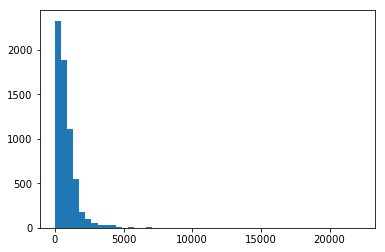

In [6]:
plt.hist([len(t) for t in int_text],50)
plt.show()

In [7]:
print('The number of articles greater than 500 in length is: ', np.sum(np.array([len(t)>500 for t in int_text])))
print('The number of articles less than 50 in length is: ', np.sum(np.array([len(t)<50 for t in int_text])))

The number of articles greater than 500 in length is:  3714
The number of articles less than 50 in length is:  440


You cannot pass differing lengths of sentences to the algorithm. Hence we shall prepad the sentence with `<PAD>`. Sequences less than 500 in length will be prepadded and sequences that are longer than 500 will be truncated. It is assumed that the sentiment of the review can be asserted from the first 500 words.

In [8]:
num2word[len(word2num)] = '<PAD>'
word2num['<PAD>'] = len(word2num)

for i, t in enumerate(int_text):
    if len(t)<500:
        int_text[i] = [word2num['<PAD>']]*(500-len(t)) + t
    elif len(t)>500:
        int_text[i] = t[:500]
    else:
        continue

x = np.array(int_text)
y = (df.label.values=='REAL').astype('int')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

A real news article:

In [10]:
df[df.label=='REAL'].text.values[0]

'u . s . secretary of state john f . kerry said monday that he will stop in paris later this week amid criticism that no top american officials attended sundays unity march against terrorism . kerry said he expects to arrive in paris thursday evening as he heads home after a week abroad . he said he will fly to france at the conclusion of a series of meetings scheduled for thursday in sofia bulgaria . he plans to meet the next day with foreign minister laurent fabius and president francois hollande then return to washington . the visit by kerry who has family and childhood ties to the country and speaks fluent french could address some of the criticism that the united states snubbed france in its darkest hour in many years . the french press on monday was filled with questions about why neither president obama nor kerry attended sundays march as about 40 leaders of other nations did . obama was said to have stayed away because his own security needs can be taxing on a country and kerry

A fake news article:

In [12]:
df[df.label=='FAKE'].text.values[0]

'daniel greenfield a shillman journalism fellow at the freedom center is a new york writer focusing on radical islam . in the final stretch of the election hillary rodham clinton has gone to war with the fbi . the word unprecedented has been thrown around so often this election that it ought to be retired . but its still unprecedented for the nominee of a major political party to go war with the fbi . but thats exactly what hillary and her people have done . coma patients just waking up now and watching an hour of cnn from their hospital beds would assume that fbi director james comey is hillarys opponent in this election . the fbi is under attack by everyone from obama to cnn . hillarys people have circulated a letter attacking comey . there are currently more media hit pieces lambasting him than targeting trump . it wouldnt be too surprising if the clintons or their allies were to start running attack ads against the fbi . the fbis leadership is being warned that the entire leftwing 

## Many to One LSTM

### Basic Method:
This method is no different to the method utilised in the sentiment analysis lesson.

In [13]:
model = Sequential()
# TODO: complete rest of model structure
# 1. Add an embedding layer
# 2. Add an LSTM layer
# 3. Add a Dense Layer (what should be the activation)
# 4. Compile the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          2988500   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,018,005.0
Trainable params: 3,018,005
Non-trainable params: 0.0
_________________________________________________________________


In [171]:
batch_size = 128
epochs = 30
v = 0
for i in range(epochs):
    if i% (epochs//10) == 0 or i == epochs - 1:
        v = 1
        print('Epoch ',i+1,'/',epochs)
    model.fit(X_train, y_train, batch_size=batch_size, epochs=1, validation_data=(X_test, y_test),
             verbose=v)
    v = 0

Epoch  1 / 30
Train on 5701 samples, validate on 634 samples
Epoch 1/1
5701/5701 [==============================] - 50s - loss: 0.6170 - acc: 0.6662 - val_loss: 0.4496 - val_acc: 0.8297
Epoch  4 / 30
Train on 5701 samples, validate on 634 samples
Epoch 1/1
5701/5701 [==============================] - 57s - loss: 0.1815 - acc: 0.9444 - val_loss: 0.2737 - val_acc: 0.9101
Epoch  7 / 30
Train on 5701 samples, validate on 634 samples
Epoch 1/1
5701/5701 [==============================] - 56s - loss: 0.0817 - acc: 0.9786 - val_loss: 0.3077 - val_acc: 0.9101
Epoch  10 / 30
Train on 5701 samples, validate on 634 samples
Epoch 1/1
5701/5701 [==============================] - 56s - loss: 0.0234 - acc: 0.9940 - val_loss: 0.4101 - val_acc: 0.9022
Epoch  13 / 30
Train on 5701 samples, validate on 634 samples
Epoch 1/1
5701/5701 [==============================] - 56s - loss: 0.0080 - acc: 0.9972 - val_loss: 1.3542 - val_acc: 0.7823
Epoch  16 / 30
Train on 5701 samples, validate on 634 samples
Epoch 

### Method 2: Fixed Embeddings
This is where we use the `Embedding2` class to which we give a set of weights which remain the same through training. Note especially the number of trainable parameters in the summary.

In [161]:
model = Sequential()
model.add(Embedding2(len(word2num), 50,
                    fixed_weights=np.array([word2glove[w] for w in words_in_glove]))) # , batch_size=batch_size
# TODO: complete model (same as above)
# 1. ADD LSTM layer
# 2. ADD Dense layer
# 3. Compile the model 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding2_18 (Embedding2)   (None, None, 50)          2988500   
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 3,018,005.0
Trainable params: 116,355
Non-trainable params: 2,901,650.0
_________________________________________________________________


I may heave cheated and run the following block 3 times. Good thing about Keras is that it remembers the last learning rate and goes from there.

In [164]:
batch_size = 128
model.fit(X_train, y_train, batch_size=batch_size, epochs=10, validation_data=(X_test, y_test))

Train on 5701 samples, validate on 634 samples
Epoch 1/10
5701/5701 [==============================] - 38s - loss: 0.4107 - acc: 0.8237 - val_loss: 0.3964 - val_acc: 0.8360
Epoch 2/10
5701/5701 [==============================] - 38s - loss: 0.3760 - acc: 0.8442 - val_loss: 0.3649 - val_acc: 0.8612
Epoch 3/10
5701/5701 [==============================] - 40s - loss: 0.3764 - acc: 0.8367 - val_loss: 0.3480 - val_acc: 0.8470
Epoch 4/10
5701/5701 [==============================] - 52s - loss: 0.3912 - acc: 0.8248 - val_loss: 0.3652 - val_acc: 0.8328
Epoch 5/10
5701/5701 [==============================] - 57s - loss: 0.3538 - acc: 0.8499 - val_loss: 0.3383 - val_acc: 0.8659
Epoch 6/10
5701/5701 [==============================] - 50s - loss: 0.3544 - acc: 0.8506 - val_loss: 0.3300 - val_acc: 0.8628
Epoch 7/10
5701/5701 [==============================] - 47s - loss: 0.3360 - acc: 0.8546 - val_loss: 0.3101 - val_acc: 0.8817
Epoch 8/10
5701/5701 [==============================] - 46s - loss: 0.3

In [70]:
sentence = "bananas are the shit .".lower()
sentence_num = [word2num[w] if w in word2num else word2num['<Other>'] for w in sentence.split()]
sentence_num = [word2num['<PAD>']]*(500-len(sentence_num)) + sentence_num
sentence_num = np.array(sentence_num)
model.predict(sentence_num[None,:])

array([[ 0.23917833]], dtype=float32)

In [56]:
word2num['washington']

2000

In [61]:
model.get_weights()[0][word2num['trump']]

0.045752164

In [52]:
model.get_weights()[0][word2num['hitler']]

array([ 0.0724525 ,  0.08280965, -0.02879164,  0.05881409, -0.09918024,
        0.01381111,  0.07768132,  0.07549043, -0.00173298,  0.01198985,
       -0.00075917,  0.08376655, -0.04371177, -0.01928549, -0.0648638 ,
       -0.04243313,  0.07026096, -0.05594615, -0.04879339, -0.002394  ,
       -0.0654976 , -0.04284219,  0.05113008,  0.07402544,  0.04351413,
       -0.02956773,  0.07595408,  0.05105161, -0.00978376, -0.00744698,
        0.00084596,  0.06842799], dtype=float32)